# To do
    Need to check the problem with plate locations (should be corrected)
    Check fillna, and for possible better solution
    double check target and feature are correct
    verify seasonality 
    remove commented out code
    simplify code until model predicts in realistics range (then add back time features)
    tune hyper parameters best model
    pull historical data from USGS
    create a few visuals 


# Combining Classification and Temporal Features:
 * Geopandas for Regional Data: Use geopandas to associate earthquakes with specific regions (e.g., California, specific areas of India).
 * Feature Engineering (Temporal and Non-Temporal):
   * Temporal Features:
     * Time since the last significant earthquake in the region.
     * Number of smaller earthquakes in the region within the past month, 3 months, 6 months.
     * Rolling averages of seismic activity.
   * Non-Temporal Features:
     * Magnitude of the largest earthquake in the region's historical record.
     * Fault line characteristics (if you can obtain this data).
     * Location Data.
 * Classification Model:
   * Use a gradient boosting or random forest model to predict the probability of an earthquake exceeding your magnitude threshold within the next month.
 * Tableau Dashboard:
   * Visualize the predicted probabilities, historical earthquake data, and relevant features on your dashboard.

In [28]:
import pandas as pd
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import warmings
import geopandas as gpd
from statsmodels.tsa.statespace.sarimax import SARIMAX

ModuleNotFoundError: No module named 'warmings'

In [ ]:
# Set Up the URL 
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2022-06-01",
    "endtime": "2025-02-28",
    "minmagnitude": 4.5,
}

# Send the Request and Check the Response
response = requests.get(url, params=params)
print(f"Response Status Code: {response.status_code}")
if response.status_code == 200:
    earthquake_data = response.json()
    print("Number of earthquakes:", len(earthquake_data["features"]))
    print("First earthquake:", earthquake_data["features"][0])
elif response.status_code == 400:
    print("Bad Request Error: Check URL and parameters")
    print(response.text)  # Print the full response text for debugging
else:
    print("Error:", response.status_code)

# Ensure the DataFrame df is only created if the response is successful
if response.status_code == 200:
    # Parse the GeoJSON Data and Extract Information
    earthquake_list = []
    for feature in earthquake_data["features"]:
        earthquake = {
            "type": feature["type"],
            "geometry": feature["geometry"],
            "id": feature["id"]
        }
        for key, value in feature["properties"].items():
            earthquake[key] = value
        earthquake_list.append(earthquake)
    df = pd.DataFrame(earthquake_list)
else:
    print("DataFrame 'df' is not defined. Check for issues in the data extraction steps.")
    
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)

Response Status Code: 200
Number of earthquakes: 19586
First earthquake: {'type': 'Feature', 'properties': {'mag': 5, 'place': '55 km NE of Adak, Alaska', 'time': 1740692910442, 'updated': 1741039124800, 'tz': None, 'url': 'https://earthquake.usgs.gov/earthquakes/eventpage/us6000pvws', 'detail': 'https://earthquake.usgs.gov/fdsnws/event/1/query?eventid=us6000pvws&format=geojson', 'felt': 2, 'cdi': 2.7, 'mmi': 3.247, 'alert': None, 'status': 'reviewed', 'tsunami': 0, 'sig': 385, 'net': 'us', 'code': '6000pvws', 'ids': ',us6000pvws,usauto6000pvws,ak0252o9z9b7,ak0252o9yl4l,', 'sources': ',us,usauto,ak,ak,', 'types': ',associate,dyfi,internal-moment-tensor,oaf,origin,phase-data,shakemap,', 'nst': 136, 'dmin': 0.124, 'rms': 1.06, 'gap': 93, 'magType': 'mww', 'type': 'earthquake', 'title': 'M 5.0 - 55 km NE of Adak, Alaska'}, 'geometry': {'type': 'Point', 'coordinates': [-176.043, 52.2176, 131.13]}, 'id': 'us6000pvws'}


In [ ]:
# Extract Latitude, Longitude, and Depth from geometry
if 'df' in locals():
    df['latitude'] = df['geometry'].apply(lambda x: x['coordinates'][1])
    df['longitude'] = df['geometry'].apply(lambda x: x['coordinates'][0])
    df['depth'] = df['geometry'].apply(lambda x: x['coordinates'][2])

    # Convert Timestamp to Datetime
    df['time'] = pd.to_datetime(df['time'], unit='ms')

    # Drop the geometry column if no longer needed
    df.drop(columns=['geometry'], inplace=True)

    # Display DataFrame information
    display(df.info())
else:
    print("DataFrame 'df' is not defined. Check for issues in the data extraction steps.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19586 entries, 0 to 19585
Data columns (total 30 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   type       19586 non-null  object        
 1   id         19586 non-null  object        
 2   mag        19586 non-null  float64       
 3   place      19586 non-null  object        
 4   time       19586 non-null  datetime64[ns]
 5   updated    19586 non-null  int64         
 6   tz         0 non-null      object        
 7   url        19586 non-null  object        
 8   detail     19586 non-null  object        
 9   felt       3950 non-null   float64       
 10  cdi        3950 non-null   float64       
 11  mmi        2041 non-null   float64       
 12  alert      1773 non-null   object        
 13  status     19586 non-null  object        
 14  tsunami    19586 non-null  int64         
 15  sig        19586 non-null  int64         
 16  net        19586 non-null  object       

None

In [ ]:
# Reset index and retain the 'time' column
df.reset_index(drop=False, inplace=True)

# Convert DataFrame to GeoDataFrame
def create_geodataframe(df):
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    return gdf

# Create a GeoDataFrame
gdf = create_geodataframe(df)

# Set Coordinate Reference System (CRS)
gdf.set_crs(epsg=4326, inplace=True)

# Path to the extracted shapefile directory
extract_to_path = r'C:\Users\thoma\Documents\GitHub\USGS\Tectonic_Plates_and_Boundaries'
shapefile_path = os.path.join(extract_to_path, 'Tectonic_Plates_and_Boundaries.shp')

# Load the shapefile using GeoPandas
if os.path.exists(shapefile_path):
    tectonic_plates = gpd.read_file(shapefile_path)
    print("Shapefile loaded successfully.")
    display(tectonic_plates.head())
else:
    print("Shapefile not found. Please check the path.")

# Ensure the tectonic plates GeoDataFrame has the same CRS as the earthquake GeoDataFrame
tectonic_plates = tectonic_plates.to_crs(gdf.crs)

# Check for and fix any invalid geometries
gdf = gdf[gdf.is_valid]
tectonic_plates = tectonic_plates[tectonic_plates.is_valid]

# Ensure 'time' column is preserved before spatial join
gdf['time'] = pd.to_datetime(gdf['time'])

# Perform spatial join to associate each earthquake with the corresponding tectonic plate
gdf = gpd.sjoin(gdf, tectonic_plates, how='left', predicate='intersects', lsuffix='left', rsuffix='right')

# Rename the column for clarity
gdf.rename(columns={'PlateName': 'tectonic_plate'}, inplace=True)

# Verify the results of the renaming
print("Columns after renaming:")
display(gdf.columns)

# Ensure 'time' column is still present
if 'time' not in gdf.columns:
    raise KeyError("'time' column is missing after spatial join")

# Ensure 'time' column is in datetime format
gdf['time'] = pd.to_datetime(gdf['time'])


Shapefile loaded successfully.


,OBJECTID,Code,PlateName,Shape__Are,Shape__Len,geometry
0,1,AF,Africa,7.321846e+13,4.963234e+07,"POLYGON Z ((-48746.805 -7333156.477 0, -101818..."
1,2,AN,Antarctica,9.350352e+14,1.459012e+08,"POLYGON Z ((-20037507.067 -9808593.925 0, -199..."
2,3,SO,Somalia,2.174794e+13,2.599516e+07,"POLYGON Z ((3576227.697 -5942041.427 0, 357616..."
3,4,IN,India,1.352969e+13,1.809340e+07,"POLYGON Z ((6263413.413 1645813.193 0, 6345377..."
4,5,AU,Australia,6.350938e+13,4.931614e+07,MULTIPOLYGON Z (((-20037507.067 -1760839.892 0...


Columns after renaming:


Index(['index', 'type', 'id', 'mag', 'place', 'time', 'updated', 'tz', 'url',
       'detail', 'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig',
       'net', 'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'title', 'latitude', 'longitude', 'depth', 'geometry',
       'index_right', 'OBJECTID', 'Code', 'tectonic_plate', 'Shape__Are',
       'Shape__Len'],
      dtype='object')

In [ ]:
# Calculate time since last significant earthquake within each tectonic plate
gdf['time_since_last'] = gdf.groupby('tectonic_plate')['time'].diff().dt.days

# Vectorized count of smaller earthquakes in past 1, 3, and 6 months within each tectonic plate
gdf['count_1m'] = gdf.groupby('tectonic_plate')['time'].transform(lambda x: (x >= (x.max() - pd.Timedelta(days=30))).sum())
gdf['count_3m'] = gdf.groupby('tectonic_plate')['time'].transform(lambda x: (x >= (x.max() - pd.Timedelta(days=90))).sum())
gdf['count_6m'] = gdf.groupby('tectonic_plate')['time'].transform(lambda x: (x >= (x.max() - pd.Timedelta(days=180))).sum())

# Rolling averages of seismic activity within each tectonic plate
gdf['rolling_avg_3m'] = gdf.groupby('tectonic_plate')['mag'].transform(lambda x: x.rolling(window=90, min_periods=1).mean())

# Fill NA values with appropriate values (e.g., 0 for counts)
gdf.fillna(0, inplace=True)

# Display DataFrame information
print(gdf.info())

# Save the updated GeoDataFrame to a CSV file at the specified location
csv_file_path = r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_plates.csv"
gdf.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 19586 entries, 0 to 19585
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   index            19586 non-null  int64         
 1   type             19586 non-null  object        
 2   id               19586 non-null  object        
 3   mag              19586 non-null  float64       
 4   place            19586 non-null  object        
 5   time             19586 non-null  datetime64[ns]
 6   updated          19586 non-null  int64         
 7   tz               19586 non-null  int64         
 8   url              19586 non-null  object        
 9   detail           19586 non-null  object        
 10  felt             19586 non-null  float64       
 11  cdi              19586 non-null  float64       
 12  mmi              19586 non-null  float64       
 13  alert            19586 non-null  object        
 14  status           19586 non-null  ob

C:\Users\thoma\AppData\Local\Temp\ipykernel_17796\3226859112.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf.fillna(0, inplace=True)


Data saved to C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_plates.csv


In [ ]:
# Verify the results of the renaming
#display(gdf.columns)
#display(gdf.head())


# Preprocess

# Generate SARIMA Feature

In [7]:
# Prepare Time Series Data for SARIMA
# Aggregate earthquake data by month for each tectonic plate
gdf['year_month'] = gdf['time'].dt.to_period('M')
monthly_counts = gdf.groupby(['tectonic_plate', 'year_month']).size().unstack(fill_value=0)

# Fit SARIMA model for each tectonic plate
sarima_forecasts = {}
for plate in monthly_counts.index:
    ts_data = monthly_counts.loc[plate]
    model = SARIMAX(ts_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = model.fit(disp=False)
    forecast = results.get_forecast(steps=12)  # Forecast next 12 months
    sarima_forecasts[plate] = forecast.predicted_mean

# Add SARIMA forecast as a new feature
for plate, forecast in sarima_forecasts.items():
    gdf.loc[gdf['tectonic_plate'] == plate, 'sarima_forecast'] = forecast.values[-1]

# Ensure SARIMA forecast feature is filled for all rows
gdf['sarima_forecast'].fillna(0, inplace=True)

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros

# Generate Target Prediction

In [8]:
# Threshold magnitude for earthquake
#threshold_magnitude = 6.0 

# Define the function to create the target variable for training
#def create_training_target(df, threshold_magnitude):
#    df['target_next_month'] = df['mag'].apply(lambda x: 1 if x >= threshold_magnitude else 0)
#    return df

# Apply the function to create the target variable for training
#gdf = create_training_target(gdf, threshold_magnitude)


# EDA

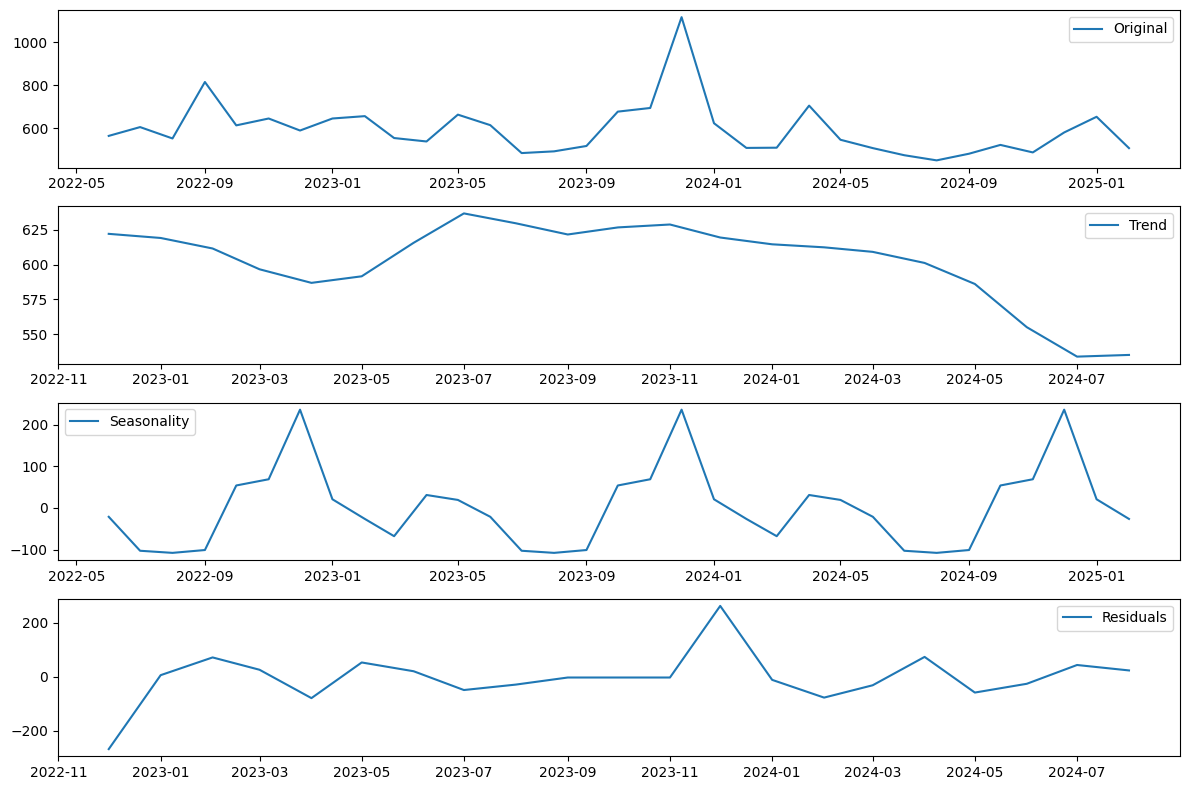

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Convert 'time' column to datetime if not already
gdf['time'] = pd.to_datetime(gdf['time'], errors='coerce')

# Aggregate earthquake data by month
gdf['year_month'] = gdf['time'].dt.to_period('M')
monthly_counts = gdf.groupby('year_month').size()

# Ensure the data is sorted by time
monthly_counts = monthly_counts.sort_index()

# Convert PeriodIndex to DatetimeIndex for plotting
monthly_counts.index = monthly_counts.index.to_timestamp()

# Specify the period (e.g., 12 for monthly data)
decomposition = seasonal_decompose(monthly_counts, model='additive', period=12)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(monthly_counts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()



In [10]:
# Encode 'magType'
if 'magType' in gdf.columns:
    unique_magtypes = sorted(gdf['magType'].unique())
    magtype_mapping = {magtype: i+1 for i, magtype in enumerate(unique_magtypes)}
    gdf['magType_encoded'] = gdf['magType'].map(magtype_mapping)
    display(gdf[['magType', 'magType_encoded']].head())
else:
    print("'magType' column not found in the DataFrame.")

# Encode 'tectonic_plate'
if 'tectonic_plate' in gdf.columns:
    unique_plates = sorted(gdf['tectonic_plate'].unique())
    plate_mapping = {plate: i+1 for i, plate in enumerate(unique_plates)}
    gdf['tectonic_plate_encoded'] = gdf['tectonic_plate'].map(plate_mapping)
    display(gdf[['tectonic_plate', 'tectonic_plate_encoded']].head())
else:
    print("'tectonic_plate' column not found in the DataFrame.")

# Display updated DataFrame information
#display(gdf.columns)

,magType,magType_encoded
0,mww,10
1,mb,1
2,mb,1
3,mb,1
4,mb,1


,tectonic_plate,tectonic_plate_encoded
0,North America,32
1,Eurasia,18
2,Africa,2
3,Timor,49
4,Sunda,48


In [11]:
# Ensure the 'magType' column is available
#if 'magType' in df.columns:
    # Create a sorted list of unique 'magType' values
#    unique_magtypes = sorted(df['magType'].unique())
    
    # Create a mapping from unique 'magType' values to integers
#    magtype_mapping = {magtype: i+1 for i, magtype in enumerate(unique_magtypes)}
    
    # Map 'magType' to corresponding integers
#    df['magType_encoded'] = df['magType'].map(magtype_mapping)
    
#else:
#    print("'magType' column not found in the DataFrame.")


# Display updated DataFrame information
#display(gdf.columns)
#display(gdf.info())

In [12]:
# Threshold magnitude for earthquake
threshold_magnitude = 6.0 

# Define date ranges for feature and target extraction
last_date = gdf['time'].max()
start_date = last_date - pd.DateOffset(days=30)

# Create 'target_prediction' column
gdf['target_prediction'] = ((gdf['mag'] >= threshold_magnitude) & (gdf['time'] >= start_date) & (gdf['time'] <= last_date)).astype(int)

# Display the updated DataFrame with the new column
display(gdf[['time', 'mag', 'target_prediction']].head(10))


,time,mag,target_prediction
0,2025-02-27 21:48:30.442,5.0,0
1,2025-02-27 21:06:10.273,5.5,0
2,2025-02-27 20:00:42.970,5.0,0
3,2025-02-27 15:52:59.020,5.1,0
4,2025-02-27 15:30:42.635,4.7,0
5,2025-02-27 14:54:37.188,5.5,0
6,2025-02-27 13:26:39.271,4.8,0
7,2025-02-27 10:23:25.016,4.5,0
8,2025-02-27 08:27:47.775,4.7,0
9,2025-02-27 08:19:58.079,4.7,0


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Threshold magnitude for earthquake
threshold_magnitude = 6.0 

# Define features and target
features = ['time_since_last', 'count_1m', 'count_3m', 'count_6m', 'rolling_avg_3m', 'latitude', 'longitude', 'sarima_forecast', 'depth', 'sig', 'dmin', 'rms', 'gap', 'Shape__Len', 'magType_encoded', 'tectonic_plate_encoded']

# Extract features and target variable
X = gdf[features]
y = gdf['target_prediction']

# Handle any missing target values
y = y.fillna(0).astype(int)  # Fill missing target values with 0

# Use stratified sampling for splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Save training data to CSV
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv('train_data.csv', index=False)

# Save test data to CSV
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv('test_data.csv', index=False)

print("Training and test data files created successfully!")

Training and test data files created successfully!


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Train Logistic Regression model with increased iterations and alternative solver
lr_model = LogisticRegression(random_state=42, max_iter=1000, solver='saga')
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_prob_lr)

print("Logistic Regression Accuracy (Next Month):", round(accuracy_lr, 3))
print("Logistic Regression ROC-AUC Score (Next Month):", round(roc_auc_lr, 3))

# Summarize the overall probability
overall_prob_lr = y_prob_lr.mean()
print(f"Overall probability of a magnitude 6.0 or above earthquake happening next month: {overall_prob_lr:.2f}")

Logistic Regression Accuracy (Next Month): 1.0
Logistic Regression ROC-AUC Score (Next Month): 0.001
Overall probability of a magnitude 6.0 or above earthquake happening next month: 0.00


# Feature Importance

In [15]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
roc_auc_gb = roc_auc_score(y_test, y_prob_gb)

print("Gradient Boosting Accuracy (Next Month):", round(accuracy_gb, 3))
print("Gradient Boosting ROC-AUC Score (Next Month):", round(roc_auc_gb, 3))

# Feature Importance
importances_gb = gb_model.feature_importances_
feature_names = features

# Create a DataFrame for better visualization
feature_importance_df_gb = pd.DataFrame({'Feature': feature_names, 'Importance': importances_gb})
feature_importance_df_gb = feature_importance_df_gb.sort_values(by='Importance', ascending=False)

print("Gradient Boosting Feature Importance (Next Month):")
print(feature_importance_df_gb)



Gradient Boosting Accuracy (Next Month): 1.0
Gradient Boosting ROC-AUC Score (Next Month): 0.506
Gradient Boosting Feature Importance (Next Month):
                   Feature  Importance
4           rolling_avg_3m    0.341836
8                    depth    0.326993
15  tectonic_plate_encoded    0.240730
9                      sig    0.029942
7          sarima_forecast    0.012976
6                longitude    0.012852
1                 count_1m    0.011632
2                 count_3m    0.009844
3                 count_6m    0.009395
12                     gap    0.003801
0          time_since_last    0.000000
5                 latitude    0.000000
10                    dmin    0.000000
11                     rms    0.000000
13              Shape__Len    0.000000
14         magType_encoded    0.000000


In [16]:
# Save the updated GeoDataFrame to a CSV file at the specified location
csv_file_path = r"C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_plates2.csv"
gdf.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

Data saved to C:\Users\thoma\Documents\GitHub\USGS\earthquake_data_with_plates2.csv


# Model

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score

In [18]:
# select magnitude 
threshold_magnitude = 6.0

# Display the top 10 most common values in the 'tectonic_plate' column
most_common_plates = gdf['tectonic_plate'].value_counts().head(20)
print(most_common_plates)

tectonic_plate
Sunda             2183
Australia         1367
Eurasia           1281
Philippine Sea    1260
Pacific           1113
South America     1095
North America      996
Kermadec           895
Okhotsk            810
New Hebrides       717
Tonga              652
Mariana            590
Sandwich           577
Antarctica         494
South Bismarck     477
Africa             458
Somalia            376
Banda Sea          362
Altiplano          298
Caribbean          276
Name: count, dtype: int64


In [19]:
# Filter Plate
#display(gdf.columns)

#plate = 'Africa' 
#def filter_tectonic_plate(gdf_encoded, plate_name):
#    return gdf_encoded[gdf_encoded['tectonic_plate'] == plate_name]

# Apply the filter function to select data for the Indian Plate
#gdf_plate = filter_tectonic_plate(gdf, plate)
#display(gdf_plate.info())

In [20]:
# Handle any missing target values
y = y.fillna(0).astype(int)  # Fill missing target values with 0

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check class distribution in the training set
print("Class distribution in y_train:")
print(y_train.value_counts())

# Apply SMOTE to balance the target variable in the training set with reduced n_neighbors
smote = SMOTE(random_state=42, k_neighbors=2)  # Reduce n_neighbors to 2
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Apply StandardScaler to the resampled data
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing with SMOTE and StandardScaler completed successfully!")


Class distribution in y_train:
target_prediction
0    15665
1        3
Name: count, dtype: int64
Data preprocessing with SMOTE and StandardScaler completed successfully!


In [21]:
# Define features and target variable with encoded columns
#features = ['time_since_last', 'count_1m', 'count_3m', 'count_6m', 'rolling_avg_3m', 'latitude', 'longitude', 'sarima_forecast', 'depth', 'sig', 'dmin', 'rms', 'gap', 'Shape__Len', 'magType_encoded']

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#y = gdf['target_next_month'] 

# Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:

# Train the Logistic Regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=1000)
log_reg_model.fit(X_train, y_train)

# Make predictions for Logistic Regression
y_pred_log_reg = log_reg_model.predict(X_test)
y_prob_log_reg = log_reg_model.predict_proba(X_test)[:, 1]

# Evaluate the Logistic Regression model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
roc_auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)

print("Logistic Regression Accuracy (Next Month):", round(accuracy_log_reg, 3))
print("Logistic Regression ROC-AUC Score (Next Month):", round(roc_auc_log_reg, 3))


Logistic Regression Accuracy (Next Month): 1.0
Logistic Regression ROC-AUC Score (Next Month): 0.001


In [23]:
# next month gradient boost
gb_model_z = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model_z.fit(X_train, y_train)

# Make predictions
y_pred_gb_z = gb_model_z.predict(X_test)
y_prob_gb_z = gb_model_z.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_gb_z = accuracy_score(y_test, y_pred_gb_z)
roc_auc_gb_z = roc_auc_score(y_test, y_prob_gb_z)

print("Gradient Boosting Accuracy (Next Month):", round(accuracy_gb_z, 3))
print("Gradient Boosting ROC-AUC Score (Next Month):", round(roc_auc_gb_z, 3))


Gradient Boosting Accuracy (Next Month): 1.0
Gradient Boosting ROC-AUC Score (Next Month): 0.506


In [24]:

# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

print("Random Forest Accuracy (Next Month):", round(accuracy_rf, 10))
print("Random Forest ROC-AUC Score (Next Month):", round(roc_auc_rf, 10))


Random Forest Accuracy (Next Month): 0.9997447677
Random Forest ROC-AUC Score (Next Month): 0.9941281593


In [25]:
# next months gradient cat boost
catboost_model_z = CatBoostClassifier(iterations=100, random_state=42, verbose=0)
catboost_model_z.fit(X_train, y_train)

# Make predictions
y_pred_cb_z = catboost_model_z.predict(X_test)
y_prob_cb_z = catboost_model_z.predict_proba(X_test)[:, 1]

# Evaluate the CatBoost model
accuracy_cb_z = accuracy_score(y_test, y_pred_cb_z)
roc_auc_cb_z = roc_auc_score(y_test, y_prob_cb_z)

print("CatBoost Accuracy (Next Month):", round(accuracy_cb_z, 10))
print("CatBoost ROC-AUC Score (Next Month):", round(roc_auc_cb_z, 10))


CatBoost Accuracy (Next Month): 0.9997447677
CatBoost ROC-AUC Score (Next Month): 0.9954046464


# Hyperparameter Tuning and Cross-Validation

In [26]:
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Define features and target
features = ['time_since_last', 'count_1m', 'count_3m', 'count_6m', 'rolling_avg_3m', 'latitude', 'longitude', 'sarima_forecast', 'depth', 'sig', 'dmin', 'rms', 'gap', 'Shape__Len', 'magType_encoded', 'tectonic_plate_encoded']
X = gdf[features]
y = gdf['target_prediction']

# Handle any missing target values
y = y.fillna(0).astype(int)  # Fill missing target values with 0

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the target variable in the training set with reduced n_neighbors
smote = SMOTE(random_state=42, k_neighbors=2)  # Reduce n_neighbors to 2
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Apply StandardScaler to the resampled data
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'iterations': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_resampled_scaled, y_resampled)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_model.predict(X_test_scaled)
y_prob_best = best_model.predict_proba(X_test_scaled)[:, 1]

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_prob_best)

print("Best CatBoost Accuracy (Next Month):", round(accuracy_best, 3))
print("Best CatBoost ROC-AUC Score (Next Month):", round(roc_auc_best, 3))

# Cross-validate the best model to check for overfitting
cross_val_scores_best = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cross_val_scores_best}")
print(f"Mean Cross-validation ROC-AUC score: {cross_val_scores_best.mean()}")

# Evaluate Feature Importance of the best model
importances_best = best_model.feature_importances_
feature_importance_df_best = pd.DataFrame({'Feature': feature_names, 'Importance': importances_best})
feature_importance_df_best = feature_importance_df_best.sort_values(by='Importance', ascending=False)

print("Best CatBoost Feature Importance (Next Month):")
print(feature_importance_df_best)



Best CatBoost Accuracy (Next Month): 0.999
Best CatBoost ROC-AUC Score (Next Month): 0.993


NameError: name 'X_train_scaled' is not defined

# Cross-validate

In [ ]:
# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validate the model to check for overfitting
cross_val_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cross_val_scores_rf}")
print(f"Mean Cross-validation ROC-AUC score: {cross_val_scores_rf.mean()}")

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation ROC-AUC scores: [0.99345466 0.49281609 0.99553001 0.49537037        nan]
Mean Cross-validation ROC-AUC score: nan


C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoun

In [ ]:
# Cross-validate the model to check for overfitting


cross_val_scores = cross_val_score(catboost_model_z, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-validation ROC-AUC scores: {cross_val_scores}")
print(f"Mean Cross-validation ROC-AUC score: {cross_val_scores.mean()}")

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation ROC-AUC scores: [0.99968072 0.99553001 0.99042146 0.97637292        nan]
Mean Cross-validation ROC-AUC score: nan


C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoun

# Forcast

In [ ]:
# Define the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train, y_train)

# Make predictions for the next month
y_pred_new_rf = rf_model.predict(X_test)
y_prob_new_rf = rf_model.predict_proba(X_test)[:, 1]

# Summarize the overall probability
overall_prob_rf = y_prob_new_rf.mean()
print(f"Overall probability of a magnitude 6.0 or above earthquake happening next month: {overall_prob_rf:.2f}")


Overall probability of a magnitude 6.0 or above earthquake happening next month: 0.00


In [ ]:

# Assuming `catboost_model_z` is already trained
catboost_model_z = CatBoostClassifier(iterations=100, random_seed=42, verbose=0)
catboost_model_z.fit(X_train, y_train)

# Make predictions for the next month
y_pred_new = catboost_model_z.predict(X_test)
y_prob_new = catboost_model_z.predict_proba(X_test)[:, 1]

# Summarize the overall probability
overall_prob = y_prob_new.mean()
print(f"Overall probability of a magnitude 6.0 or above earthquake happening next month: {overall_prob:.2f}")




Overall probability of a magnitude 6.0 or above earthquake happening next month: 0.00
